# Training a face alignment model using supervised descent

In [2]:
import numpy as np
from sklearn.model_selection import train_test_split
from matplotlib import pyplot as plt
import cv2

### Loading facial keypoint dataset & splitting into training and testing data

In [58]:
data = np.load('face_alignment_data.npz')
X = data['images']
y = data['points']
X_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

### Viewing images and associated points

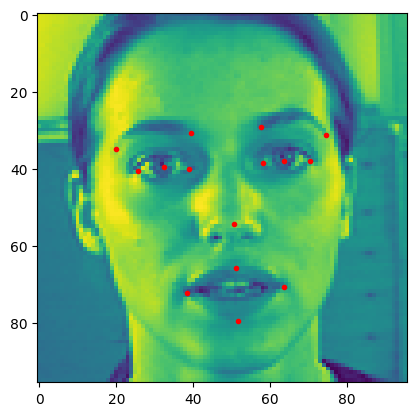

In [59]:
img_no = 9
plt.imshow(X_train[img_no])
plt.plot(y_train[img_no,:,0], y_train[img_no,:,1], 'r.') # plot associated points

### Least squares regression function
Training features and targets are centered around their respective means, with the bias being calculated from the weights and the means after regression on the centered data.

In [5]:
def regress(X, y, rcond=0.1):
    X_mean = np.average(X, axis=0)
    y_mean = np.average(y, axis=0) # feature and target means
    X_centered = X - X_mean
    y_centered = y - y_mean # centered features and targets
    weight = np.linalg.lstsq(X_centered, y_centered, rcond=rcond)[0] # regression step
    bias = y_mean - weight.T @ X_mean # calculate bias
    return weight, bias

### Training the model
The training points are flattened and averaged, with an array of initial predictions initialised by creating a 2D array containing as many copies of the flattened and averaged points as training samples. A cv2 SIFT object is created for calculating descriptors at keypoints, and empty weight and bias arrays are initialised. 

Descriptors are calculated using the initial predictions (averaged points) and regression is performed using the descriptors as features, and the difference between the initial predictions and true values as targets. After regression, the weights and biases for this step are appended to their respective arrays. The array with the initial predictions is updated, then all steps from calculating the descriptors are repeated for a given number of iterations, updating the predictions after every step. Weights and biases for each step are returned, alongside the initial calculated points.

In [36]:
def fit(X, y, its):
    n_smp = y.shape[0] # no. training samples
    true_flat = y.reshape((n_smp, -1)) # flattened points
    init_points = np.average(y, axis=0).flatten() # averaged flattened points
    preds = np.array([init_points] * n_smp) # initial predictions
    sift = cv2.SIFT_create() # create SIFT object
    weights = []
    biases = [] # weight and bias arrays, for each step
    for _ in range(its + 1):
        delta = true_flat - preds # difference between true and predicted points
        kps = [[cv2.KeyPoint(pt[0], pt[1], 4) for pt in sm] 
               for sm in preds.reshape(n_smp, -1, 2)] # create cv2 keypoints using predicted coordinates for each sample
        descs = np.array([sift.compute(i, k)[-1].flatten() 
                          for (i, k) in zip(X, kps)]) # calculate descriptors for samples at corresponding keypoints
        w, b = regress(descs, delta) # regression using calculated keypoints and difference between predicted and true values
        weights.append(w)
        biases.append(b)
        preds += descs @ w + b # update predictions for next step
    return weights, biases, init_points

In [60]:
w, b, init_points = fit(X_train, y_train, 4)

### Predicting using the model
The initial predictions as calculated during the training step are iteratively updated using the weights and biases, with descriptors being recalculated after each prediction update.

In [61]:
def predict(X, w, b, init_points, its):
    n_smp = X.shape[0] # no. training samples
    preds = np.array([init_points] * n_smp) # initial predictions
    sift = cv2.SIFT_create() # create SIFT object
    for i in range(its):
        kps = [[cv2.KeyPoint(p[0], p[1], 4) for p in pt] 
               for pt in preds.reshape(n_smp, -1, 2)] # create cv2 keypoints using predicted coordinates for each sample
        descs = np.array([sift.compute(i, k)[-1].flatten() 
                          for (i, k) in zip(X, kps)]) # calculate descriptors for samples at corresponding keypoints
        preds += descs @ w[i] + b[i] # update predictions using weights and biases for each step
    return preds

### Evaluating the model
Each line colour represents the number of iterations. Blue is 1, magenta is 2, green is 3 and red is 4. As seen there is major improvement between 1 iteration and 2 but little past that. While ~75% of the points are within 2 pixels of the predicted point on the first iteration, ~85% are on the second iteration.

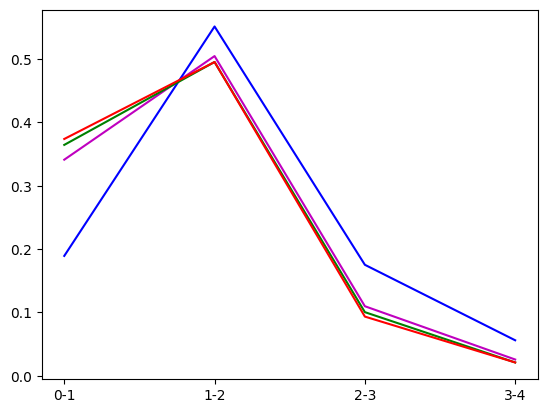

In [62]:
colours = ['b', 'm', 'g', 'r']
for j in range(1, 5):
    results = []
    preds = predict(x_test, w, b, init_points, j).reshape(x_test.shape[0], -1, 2)
    for i in [[0, 1], [1, 2], [2, 3], [3,4]]:
        u = np.average(np.sqrt(np.sum((preds-y_test)**2, axis=-1)), axis=-1) < i[1]
        l = np.average(np.sqrt(np.sum((preds-y_test)**2, axis=-1)), axis=-1) >= i[0]
        print((np.sum(np.logical_and(u, l))/len(y_test)))
        results.append(np.sum(np.logical_and(u, l))/len(y_test))
    plt.plot(results, colours[j-1])
plt.xticks([0,1,2,3], ["0-1","1-2","2-3","3-4"])
plt.show()